# Changed social influence integation with network structure

## 1. Description

In the paper and the replication notebook, the social influence on utility of a given choice is from the number of agents with choosing the same choice on the previous time step, of an *all-to-all* network of size $N=20$. The social influence "factor" is controled by $\alpha$. The equation would be as followed:

$$ 
\mathbf{Q}_t = 
    \mathbf{M}_t + 
    \left(
        \mathbf{A}_{t-1}\mathbf{W}
    \right)^{\alpha}
$$

However, this does not seem to be a good choice of social influence integration when $N$ gets larger. A way to control this is using mean social content instead. 

$$ 
\mathbf{Q}_t = 
    \gamma \mathbf{M}_t + 
    (1-\gamma) \mathbf{C}_{t-1} \psi_1\left(\mathbf{W}\right) 
    \text{ where } \mathbf{C} \in \left\{ \mathbf{M}, \mathbf{Y} \right\} 
    \text{ and } \psi_1 \text{ is a column } L^1 \text{-norm}
$$

The term $\mathbf{C}$ is called content, and can be either the belief or reward from previous time step from the neighbors. The term $\psi_1\left(\mathbf{W}\right)$ is normalizing the neighborhood with $L^1$-norm, so the social influence on choice $i$ of agent $j$ would be the mean belief (or reward) on the same choice $i$ only from neighbors of $j$. What this modification of the social integration is attempting is to have the same units between the belief influence and the mean social influence on the final utility. 

There are two variations to control social influence "factor" here. One is the explicit $\gamma$ factor to scale the mean belief and social influence. The other is the initial creation of $\mathbf{W}$ (so far still considering static social networks), in which $p_{\text{social}}$ controls the connectivity probability for an ER network.

## 2. Initialization

In [1]:
import os
if "notebooks" in os.getcwd(): os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import networkx as nx 

from tqdm.notebook import tqdm
import yaml

In [3]:
import exputils.exp1_meansocialcontent as Experiment

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.style.use(['seaborn-notebook', 'exputils/mpl.style'])

## 3. Experiment

### 3.1. Test one run

Variations on the choices of networks:

``` python
agent_social_network = nx.to_numpy_array(nx.erdos_renyi_graph(100, p = 0.1)) # -> num_agents = 100
agent_social_network = nx.to_numpy_array(nx.stochastic_block_model([50, 50], np.eye(2)*0.1 + 0.01, seed=2)) # -> num_agents = 100
agent_social_network = nx.to_numpy_array(nx.barabasi_albert_graph(100, m=3)) # -> num_agents = 100
agent_social_network = nx.to_numpy_array(nx.grid_graph((10,10))) # -> num_agents = 100
agent_social_network = nx.to_numpy_array(nx.hexagonal_lattice_graph(6,6)) # -> num_agents = 96
agent_social_network = None 
```

In [5]:
num_agents = 100

agent_social_network = nx.to_numpy_array(nx.erdos_renyi_graph(num_agents, p = 0.01))

model = Experiment.SocialMAB_ChildDev(
    num_agents = num_agents,
    social_content = 'reward', 
    social_network = agent_social_network,
    gamma = 0.8,
    BMT_error = 3600,
)

model.run(tqdm_fn = tqdm)
model.analysis['aggregate']

  0%|          | 0/1200 [00:00<?, ?it/s]

{'explore_num': array([27.25,  8.09,  0.66,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , 25.73,
        15.1 , 10.17,  5.16,  2.69,  1.18,  0.87,  0.72,  0.65,  0.78,
         0.28,  0.23,  0.34,  0.58,  0.28,  0.89]),
 'unq_choices': array([ 28.25,  36.34,  37.  ,  37.  ,  37.  ,  37.  ,  37.  ,  37.  ,
         62.54,  77.51,  87.6 ,  92.68,  95.33,  96.5 ,  97.36,  98.08,
         98.72,  99.5 ,  99.78, 100.01, 100.35, 100.93, 101.2 , 102.08]),
 'explore_ent': array([4.51216521, 4.92433394, 5.0249499 , 5.04797768, 5.04946835,
        5.0542063 , 5.05028375, 5.05213366, 5.43286996, 5.62091368,
        5.73206713, 5.77317654, 5.77837757, 5.76108027, 5.72784218,
        5.69003358, 5.64910352, 5.60715498, 5.55765039, 5.5064091 ,
        5.45257981, 5.40362221, 5.35436014, 5.30891092]),
 'mean_reward': array([11.91499979, 67.72338879, 86.31402883]),
 'loss_num': array([144.27,  58.91,  27.15]),
 'loss_mag': array([29.57625845, 67.76917633, 60.71656054]),
 'gain_num': array([254.73, 341.09, 372.85

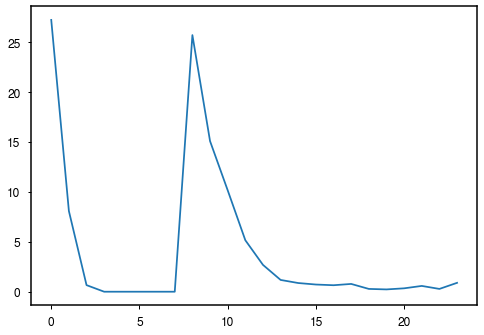

In [6]:
plt.plot(model.analysis['aggregate']['explore_num'])
plt.show()

### 3.2. Test a few variations

In [10]:
# social network constructor arguments
social_net_args = [{'type': 'None'}] +\
    [{'type': 'ER', 'p': x} for x in [0.5, 1.0]] +\
    [{'type': 'SBM', 'k': 2, 'p_max': x} for x in [0.1, 0.2]] 

In [11]:
# variation dictionary 
var_dict = dict(
    num_agents = [20],
    social_content = ['belief'],
    social_net_args = social_net_args,
    utility_gamma = [0, 0.5, 1.0],
    BMT_error = [3600]
)

In [12]:
results = Experiment.run_experiment(
    var_dict = var_dict,
    save_dir = 'data/output/test/test1', 
    save_detailed_analysis = True,
    num_trials = 3,
    max_workers = 5
)

  0%|          | 0/45 [00:00<?, ?it/s]

### 3.3. Run experiments

In [38]:
p_ER = np.logspace(-2.1, -0.05, 10)
p_max_SBM = np.logspace(-1.5, -0.1, 10)

def _p_round(p_vec, k=3): 
    return list(map(float, np.round(p_vec,k)))

social_net_args = [{'type': 'None'}] +\
    [{'type': 'ER', 'p': x} for x in _p_round(p_ER)] +\
    [{'type': 'SBM', 'k': 4, 'p_max': x} for x in _p_round(p_max_SBM)] 

In [39]:
var_dict = dict(
    num_agents = [100],
    social_content = ['belief',  'reward'],
    social_net_args = social_net_args,
    utility_gamma = [0, 0.2, 0.4, 0.6, 0.8, 1.0],
    mu0 = [100.0], 
    BMT_error = [3600]
)

In [40]:
with open(os.path.join('data/output/exp1', 'variations.yaml'), 'w') as f: 
    yaml.safe_dump(var_dict, f)

In [ ]:
results = Experiment.run_experiment(
    var_dict = var_dict,
    save_dir = 'data/output/exp1', 
    save_detailed_analysis = True,
    num_trials = 10,
    max_workers = 8,
    chunksize = 3
)

## 4. Load data and visualize

### 4.1. Load data

In [86]:
import glob
import plotly.express as px
import itertools 
from matplotlib import cm
import matplotlib as mpl

In [5]:
file_prefix = 'data/output/exp1/'
result_files = glob.glob(file_prefix + '*.parq')
var_file = file_prefix + 'variations.yaml'

print(result_files)

['data/output/exp1/reward.parq', 'data/output/exp1/variations.parq', 'data/output/exp1/explore.parq']


In [6]:
with open(var_file, 'r') as f: 
    variations = yaml.safe_load(f)


In [7]:
def process_results(file_list, drop_const_var = False):
    cols_to_drop = ['_unq_id', '_trial_id', 'file_name'] 
    
    def get_key(file_name):
        return os.path.splitext(os.path.basename(file_name))[0]
    
    dfs = {get_key(x): pd.read_parquet(x).drop(cols_to_drop, axis=1)
           for x in file_list}
    
    unq_vars = dfs['variations']\
                .drop_duplicates(ignore_index=True)\
                .set_index('_var_id')
    var_cols = unq_vars.columns
    unq_vars = unq_vars[sorted(var_cols)]
    

    for k, v in dfs.items():
        if k == 'variations': 
            dfs[k] = unq_vars.reset_index()
            continue
        dfs[k] = v.drop(var_cols, axis=1)\
                .set_index('_var_id')\
                .groupby(['_var_id', 'time'], as_index=True)\
                .mean()\
                .join(unq_vars)\
                .reset_index()
        
    if drop_const_var: 
        const_vars = unq_vars.apply(lambda g: g.nunique() == 1)
        const_vars = [k for k, v in const_vars.items() if v]
        dfs = {k: v.drop(const_vars, axis=1) for k, v in dfs.items()}
        
    return dfs 

dfs = process_results(result_files, drop_const_var=True)
                                                                   

In [122]:
dfs['variations']

,_var_id,social_content,social_net_args::p,social_net_args::p_max,social_net_args::type,utility_gamma
0,0,belief,NaN,NaN,None,0.0
1,1,belief,NaN,NaN,None,0.2
2,2,belief,NaN,NaN,None,0.4
3,3,belief,NaN,NaN,None,0.6
4,4,belief,NaN,NaN,None,0.8
...,...,...,...,...,...,...
247,247,reward,NaN,0.794,SBM,0.2
248,248,reward,NaN,0.794,SBM,0.4
249,249,reward,NaN,0.794,SBM,0.6
250,250,reward,NaN,0.794,SBM,0.8


In [12]:
dfs['explore']['social_net_args::type'].unique()

array(['None', 'ER', 'SBM'], dtype=object)

In [75]:
col_names = {k: set(v.columns) for k, v in dfs.items()}
col_names = {k: list(v - col_names['variations'] - {'time'}) if k != 'variations' else list(v) for k, v in col_names.items()}

label_names = {k: k.replace('_', ' ') for k in itertools.chain(*col_names.values())}

special_names = {
    'social_net_args::type': 'social network',
    'social_content': r'$\textit{social content}$',
    'social_net_args::p': r'$P_{\mathrm{neigh}}^{\mathrm{ER}}$',
    'social_net_args::p_max': r'$P_{\mathrm{block}}^{\mathrm{SBM}}$',
    'utility_gamma': r'$\gamma_{\mathrm{utility}}$'
}

label_names.update(special_names)

In [112]:
col_names

{'reward': ['loss_mag', 'loss_num', 'gain_mag', 'mean_reward', 'gain_num'],
 'variations': ['utility_gamma',
  'social_net_args::type',
  '_var_id',
  'social_content',
  'social_net_args::p',
  'social_net_args::p_max'],
 'explore': ['explore_ent', 'unq_choices', 'explore_num']}

### 4.2. Visualize data

View visualization [here](https://traveler4049.pythonanywhere.com/)

In [120]:
def create_cmap(cmap_name, num_colors, alpha=1.0, scale=1.0):
    cmap = cm.get_cmap(cmap_name, num_colors)(np.linspace(0,1,num_colors)) * 255 * scale
    cmap = ['rgba(%d,%d,%d,%f)' %(x[0], x[1], x[2], alpha) for x in cmap]
    return cmap 

In [150]:
import plotly.graph_objects as go 

def gen_layout():
    axis_config = dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(0, 0, 0)',
        linewidth=2,    
        ticks='outside',
        tickwidth=2
        )

    font_config = dict(
        family="FreeSans",
        size=15,
        color='black'
        )

    title_config = dict(
        title_x = 0.5,
        title_y = 0.9,
        title_xanchor = 'center',
        title_yanchor = 'top',
        title_font_size=15
    )

    axis_configs = {}
    for i in range(40):
        axis_id = '%d' %(i) if i > 0 else ''
        axis_configs['xaxis' + axis_id] = axis_config
        axis_configs['yaxis' + axis_id] = axis_config

    general_layout = go.Layout(
        width=1500,
        height=600,
        **axis_configs,
        font=font_config,
        showlegend=True,
        plot_bgcolor='white',
        paper_bgcolor='white',
        autosize=True,
        **title_config
    )
    
    return general_layout


In [ ]:
social_net_type = "ER"
social_net_var_key = 'social_net_args::p'

social_net_type = "SBM"
social_net_var_key = 'social_net_args::p_max'

df_plt = dfs['explore'].fillna(0).query('`social_net_args::type` == "None" or `social_net_args::type` == @social_net_type')

num_unq_colors = len(df_plt[social_net_var_key].unique())
cmap = create_cmap('Spectral', num_unq_colors, scale=0.9, alpha=0.8)

fig = px.line(
    df_plt,
    x = 'time', 
    y = 'explore_num', 
    color = social_net_var_key, 
    facet_col = 'utility_gamma', 
    facet_row = 'social_content',
    facet_col_spacing=0.05, 
    facet_row_spacing=0.1, 
    color_discrete_sequence=cmap,
    labels=label_names
)

for a in fig.layout.annotations:
    a_key, a_val = a.text.split("=")
    if a_key.startswith('$') and a_key.endswith('$'):
        if type(a_val) is str: 
            a_val = '\\textbf{%s}' %(a_val)
        a.text = f'${a_key[1:-1]} = {a_val}$'

fig.update_layout(general_layout)


fig.show()